In [328]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import glob
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates

from stompy import utils, memoize, filters
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy import xr_utils, xr_transect
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
import stompy.plot.cmap as scmap
from stompy.spatial import field, proj_utils 
from stompy.model import data_comparison
%matplotlib notebook
turbo=scmap.load_gradient('turbo.cpt')

In [143]:
six.moves.reload_module(xr_transect)
six.moves.reload_module(sun_driver)

<module 'stompy.model.suntans.sun_driver' from '/home/rusty/src/stompy/stompy/model/suntans/sun_driver.py'>

Check ADCP against gauge flows
---

Conclusion: River Surveyor reports flow 0.914 * Mossdale gauge, and
`xr_transect` flows are 0.918 * Mossdale gauge.

Even though xr_transect doesn't count the near-shore regions, they
are narrow, shallow, and slow in this dataset. The python results
are ever so slightly better (one less outlier) than the River Surveyor
data.

In [603]:
six.moves.reload_module(xr_transect)

# Load all of the averaged ADCP transects
# Extrapolate to bed/surface
# Add River Surveyor flow results
suffix='-avg_with_time.nc'
obs_tran_fns=glob.glob("../../field/adcp/040518_BT/*"+suffix)
obs_tran_fns.sort()
obs_trans=[]

# Load the flows as calculated by River Surveyor
rivr_Q=pd.read_csv('../../field/adcp/river_surveyor_flows-2018.csv')

# This offset is dialed in to get a match between measured flow
# and gauge flow.  Even though ADCP measured flow (as from python)
# does not include the sides, there is very little flow there, and
# without this offset, python values were almost identical to 
# river surveyor, and slightly better.
z_delta=-0.28

for fn in obs_tran_fns:
    print(fn)
    ds=xr.open_dataset(fn)
    for v in ['z_bed','depth_m']:
        if 'positive' not in ds[v].attrs:
            ds[v].attrs['positive']='down'
            assert ds[v].mean()>0,"Maybe a bad assumption here"
    ds['eta']=(-z_delta) + 0*ds.depth_m
    ds.attrs['fn']=fn
    ds.attrs['label']=os.path.basename(fn).replace(suffix,'').replace('BTref','')

    if 1:
        # A little cleanup
        # column with no bed elevation gets deleted
        ds=ds.isel(sample=np.isfinite(ds.z_bed.values))
        xr_transect.mask_bed(ds,ds.U,depth_fraction=0.75,z_top=ds.eta)
    
    ds=xr_transect.extrapolate_vertical(ds,
                                        [ ('U',dict(xy=0),'pow(0.167)','pow(0.167)'),
                                          ('U',dict(xy=1),'pow(0.167)','pow(0.167)')],
                                        eta=ds.eta.mean(),z_bed='z_bed',
                                        save_original=True)
    # Not sure where the bug is, but shift_vertical before the extrapolate call
    # does not work.
    xr_transect.shift_vertical(ds,z_delta)
    
    # Add River Surveyor Flows
    Qests=[]
    for idx,row in rivr_Q.iterrows():
        if row['filename'].startswith(ds.label):
            Qests.append(row['flow_m3s'])
    assert len(Qests)>0
    ds['Qmean']=(),np.mean(Qests)
    ds['Qstd']=(),np.std(Qests)
    ds['Qmedian']=(),np.median(Qests)
    obs_trans.append(ds)


../../field/adcp/040518_BT/040318_1_BTref-avg_with_time.nc
../../field/adcp/040518_BT/040518_2BTref-avg_with_time.nc
../../field/adcp/040518_BT/040518_3_BTref-avg_with_time.nc
../../field/adcp/040518_BT/040518_4BTref-avg_with_time.nc
../../field/adcp/040518_BT/040518_5BTref-avg_with_time.nc
../../field/adcp/040518_BT/040518_6BTref-avg_with_time.nc
../../field/adcp/040518_BT/040518_7_BTref-avg_with_time.nc
../../field/adcp/040518_BT/040518_8BTref-avg_with_time.nc
../../field/adcp/040518_BT/040518_9BTref-avg_with_time.nc


In [145]:
# Load MSD flows
local_file="msd-flow-2018.csv"
utils.download_url(local_file=local_file,
                   url=("http://wdl.water.ca.gov/waterdatalibrary/docs/"
                        "Hydstra/docs/B95820Q/2018/FLOW_15-MINUTE_DATA_DATA.CSV") )
                                 
msd_flow=pd.read_csv(local_file,skiprows=3,parse_dates=['time_pst'],
                     names=['time_pst','flow_cfs','quality','notes'])


In [146]:
msd_flow['flow_m3s']=msd_flow.flow_cfs*(0.3048)**3
msd_flow['time']=msd_flow['time_pst'] + np.timedelta64(8,'h')

In [221]:
Qs=[]
Qrivs=[]
times=[]

for tran in obs_trans:
    Q=xr_transect.Qleft(tran)
    Qr=tran.Qmean.item()
    t=tran.time.values + np.timedelta64(8,'h')
    if tran.label==obs_trans[-1].label:
        # but transects 8 and 9 downstream of the junction on either 
        # side.
        Qs[-1]+=Q
        Qrivs[-1]+=Qr
    else:
        Qs.append(Q)
        Qrivs.append(Qr)
        times.append(t)

<IPython.core.display.Javascript object>


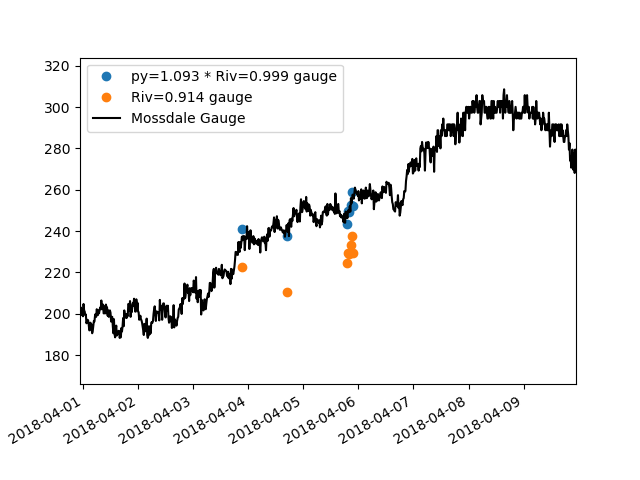

In [520]:
xr_ratio=np.mean( Qs/Q_at_transect)
riv_ratio=np.mean( Qrivs/Q_at_transect )
xr_to_riv_ratio= np.mean( np.array(Qs)/Qrivs)

fig=plt.figure()
plt.plot(times,Qs,'o',label='py=%.3f * Riv=%.3f gauge'%(xr_to_riv_ratio,xr_ratio))
plt.plot(times,Qrivs,'o',label='Riv=%.3f gauge'%(riv_ratio))

plt.plot(msd_flow.time, # -np.timedelta64(1,'h'),
         msd_flow.flow_m3s,'k-',label='Mossdale Gauge')
plt.legend()
plt.axis((736784.946, 736793.951, 166., 324.))

Q_at_transect = np.interp( times, msd_flow.time, msd_flow.flow_m3s) 
fig.autofmt_xdate()


In [876]:
six.moves.reload_module(sun_driver)
models=[
    sun_driver.SuntansModel.load("/opt2/san_joaquin/cfg008/cfg008_20180409"),
    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/cfg007_20180409"),
    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short036_20180405"),
    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady022_20180401")
]

for m in models:
    m.projection="EPSG:26910"    
    if len(models)>1:
        m.label=os.path.basename(m.run_dir)
    else:
        m.label='Model'

fig_dir=os.path.join(models[-1].run_dir,'figs-20200507')
os.path.exists(fig_dir) or os.makedirs(fig_dir)

True

In [877]:
def smooth_adcp(transect,wx=9,wz=9):
    # Smooth the observations
    U=transect.U.values
    # use an odd winsize!
    if wx:
        U=filters.lowpass_fir(transect.U.values,winsize=wx,axis=0)
    if wz:
        U=filters.lowpass_fir(U,winsize=wz,axis=1)
    transect['U']=transect['U'].dims,U
    xr_transect.add_rozovski(transect)

In [878]:
@memoize.memoize(lru=20,key_method='str')
def extract_to_match_obs(obs_tran,model,time=None):
    chain_interval=(model.chain_stop() - model.chain_start())
    steady=chain_interval<np.timedelta64(1,'D')
    if steady:
        t=-1 # choose the last step
    else:
        t=obs_tran.time.values
        if time is not None:
            t=time
    
    print(f"Extracting transect for time {t}")
    transect=model.extract_transect(xy=np.c_[obs_tran.x_sample,obs_tran.y_sample],
                                    dx=5,time=t)
    model.adjust_transect_for_dzmin_surface(transect,update_vars=['U','Ve','Vn'],
                                            dzmin_surf=0.25)
    bed_offset=np.nanmean( xr_transect.pos_up(transect,'dv')
                          - xr_transect.pos_up(obs_tran,'depth_m'))
    print("Bed offset is ",bed_offset)
    offset=np.nanmean(transect.eta.values)
    xr_transect.shift_vertical(transect,-offset)
    transect.attrs['z_shift']=-offset
    transect['depth_m']=transect['dv']
    transect.attrs['label']=model.label
    xr_transect.add_rozovski(transect)
    return transect

In [879]:
def print_flows(all_trans):
    # Report flows:
    for tran in all_trans:
        Q=xr_transect.Qleft(tran)
        print(f"{tran.label:20}: Q (xr_transect)={Q:.3f}")
        if 'Qmean' in tran:
            print(f"                      Q (river surveyor)={tran.Qmean.item():.3f}")
        print()

In [880]:
six.moves.reload_module(xr_transect)
class FigU(object):
    labels=None
    show_flow=False
    z_slice=[-2,0]
    show_bed=False
    show_surface=False
    u_cmap=turbo
    outline_valid_obs=True
    lateral_quiver=False
    
    def __init__(self,obs_tran,**kw):
        self.obs_tran=obs_tran
        utils.set_keywords(self,kw)
        self.fig=self.fig_uroz()
        
    def plot_uroz(self,tran,ax):
        coll=xr_transect.plot_scalar(tran,tran.Uroz.sel(roz='downstream'),ax=ax,
                                     cmap=self.u_cmap)
        if self.show_surface:
            ax.plot(tran.d_sample, tran.eta,'k--',label='surface')
        if self.show_bed:
            ax.plot(tran.d_sample,-tran.depth_m,'k-',label='bed')
        return coll

    def fig_uroz(self):
        obs_tran=self.obs_tran.copy()
        smooth_adcp(obs_tran)
        mod_trans=[extract_to_match_obs(obs_tran,model)
                   for model in models]
        all_trans=[obs_tran]+mod_trans

        gs=gridspec.GridSpec(len(all_trans)+1,2,width_ratios=[20,1])
        fig=plt.figure()
        axs=[]
        for i in range(len(all_trans)):
            if i==0:
                axs.append( fig.add_subplot(gs[i,:-1]))
            else:
                axs.append( fig.add_subplot(gs[i,:-1],
                                            sharex=axs[0],sharey=axs[0]))

        colls=[]
        # goofy logic to allow appending extra models without worrying about
        # adjusting names passed in.
        labels=self.labels
        if labels is None:
            labels=[]
        for i,t in enumerate(all_trans):
            if i>=len(labels):
                labels.append(t.attrs.get('label',str(i)))

        for tran,ax,label in zip(all_trans,axs,labels):
            coll=self.plot_uroz(tran,ax)
            colls.append(coll)
            ax.text(0.02,0.04,label,transform=ax.transAxes)
            if tran is not obs_tran:
                ax.plot(obs_tran.d_sample,-obs_tran.depth_m,'0.5',label='Obs. bed')
            if self.lateral_quiver:
                self.add_quiver(tran,ax)
            if self.show_flow: 
                Q=xr_transect.Qleft(tran)
                ax.text(0.5,0.02,f"Q={Q:.2f} m$^3$/s",transform=ax.transAxes,
                       va='bottom')
            ax.set_ylabel('z (m)')
            plt.setp(ax.get_xticklabels(),visible=0)
        if self.outline_valid_obs: # outline the valid ADCP data
            t=obs_tran
            ax=axs[0]
            xr_transect.contour(t,np.isfinite(t.U_nofill.isel(xy=0)),[0.9],ax=ax,
                                colors='k',linewidths=0.5,linestyles='dashed')

        axl=fig.add_subplot(gs[-1,:-1],sharex=axs[0])

        for tran,label in zip(all_trans,labels):
            # top 2m
            new_z=np.linspace(self.z_slice[0],self.z_slice[1],20)
            tran_slice=xr_transect.resample_z(tran,new_z,new_z_positive='up')
            Uslice=xr_transect.depth_avg(tran_slice,'Uroz')
            axl.plot(tran_slice.d_sample,Uslice.sel(roz='downstream'),label=label)
        axl.legend(loc='upper left',bbox_to_anchor=(1.02,1),frameon=0)
        axl.set_xlabel('Distance (m)')
        axl.set_ylabel('Velocity (m s$^{-1}$)')
        axl.axis(ymin=0)

        cax=fig.add_subplot(gs[:-1,-1])
        plt.colorbar(colls[0],cax=cax,label='m s$^{-1}$')
        plt.setp(colls,clim=[0.0,1.2])
        fig.subplots_adjust(wspace=0.07,right=0.85,top=0.97,left=0.11)

        return fig
    def add_quiver(self,tran,ax):
        x_stride=tran.dims['sample']//20
        dz=np.abs(np.nanmedian(tran.z_ctr.diff(dim='layer').values))
        z_stride=int(0.75/dz)
        t_sparse=tran.isel(sample=slice(None,None,x_stride),
                           layer=slice(None,None,z_stride))
        if 'U_nofill' in t_sparse:
            V,X,Z,Vorig = xr.broadcast(t_sparse.Uroz.isel(roz=1),
                                       t_sparse.d_sample,xr_transect.pos_up(t_sparse,'z_ctr'),
                                       t_sparse.U_nofill.isel(xy=0))
            # complicated by the fact that the extrapolation can't deal with
            # secondary flow, so lateral shows up as zero.
            valid=np.isfinite(Vorig.values)
        else:
            V,X,Z = xr.broadcast(t_sparse.Uroz.isel(roz=1),
                                 t_sparse.d_sample,xr_transect.pos_up(t_sparse,'z_ctr'))
            valid=slice(None)
        qset=ax.quiver(X.values[valid],Z.values[valid],
                       -V.values[valid],0*V.values[valid],
                       angles='xy',scale_units='width',scale=2,units='width',
                       width=0.002,pivot='mid',)
        ax.quiverkey(qset,0.9,0.05,0.1,'0.1 m s$^{-1}$',coordinates='axes')

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T11:29:30.500000000
Bed offset is  -1.5969936473118278


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T11:29:30.500000000
Bed offset is  -1.5969936473118278
Extracting transect for time -1
Bed offset is  -1.4404592021505376
Extracting transect for time -1
Bed offset is  -1.4404592021505376


<IPython.core.display.Javascript object>


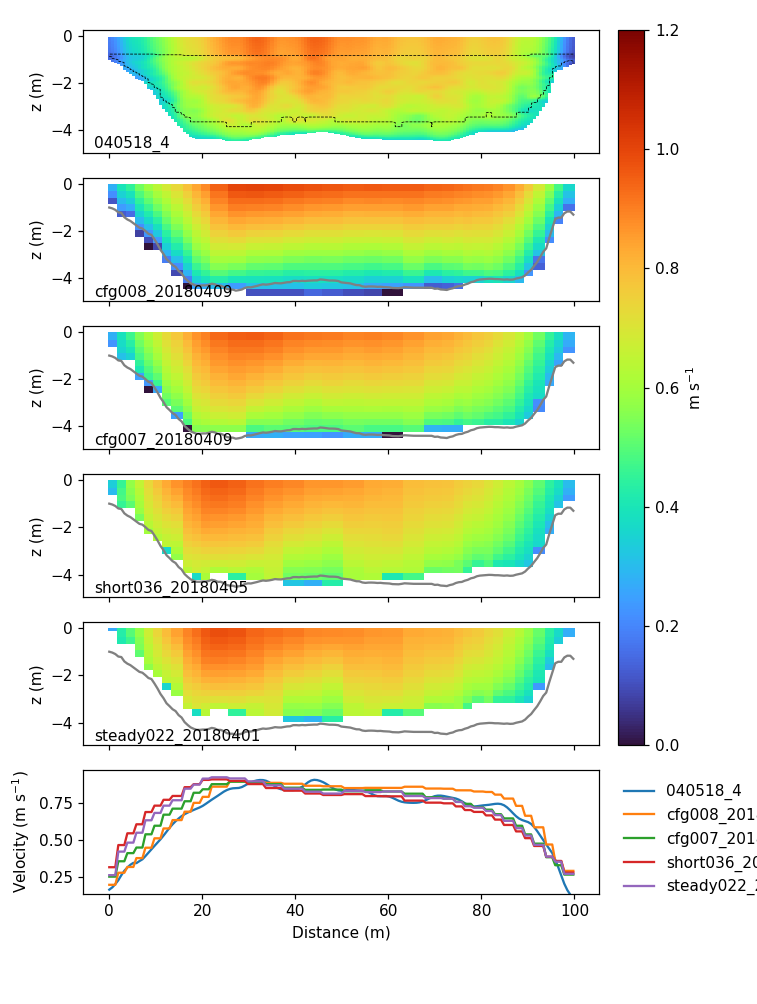

In [881]:
FigU(obs_trans[3],z_slice=[-2,0])

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-03T13:29:48.500000000
Bed offset is  -1.6180730979462874


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-03T13:29:48.500000000
Bed offset is  -1.6180730979462874
Extracting transect for time -1
Bed offset is  -1.4730292022116904
Extracting transect for time -1
Bed offset is  -1.4730292022116904


<IPython.core.display.Javascript object>


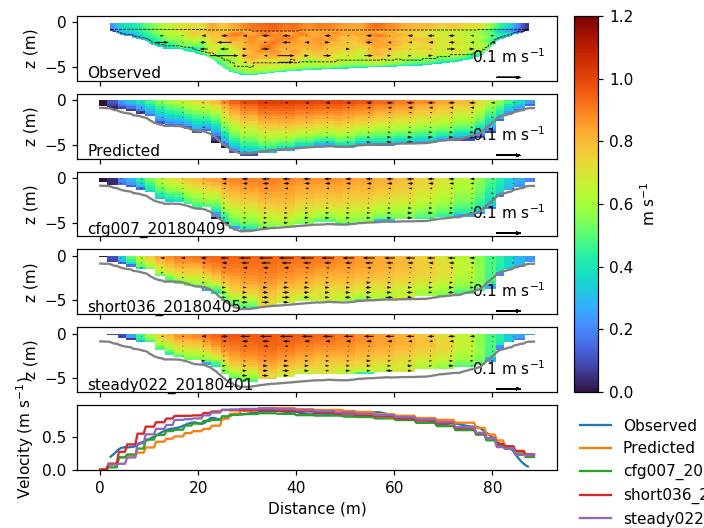

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-04T08:49:52.500000000
Bed offset is  -1.415501032720063


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-04T08:49:52.500000000
Bed offset is  -1.415501032720063
Extracting transect for time -1
Bed offset is  -1.2999786109323541
Extracting transect for time -1
Bed offset is  -1.2999786109323541


<IPython.core.display.Javascript object>


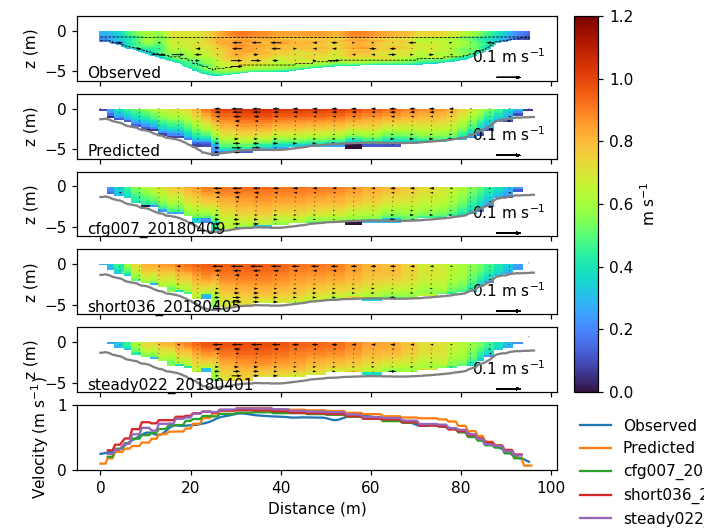

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T11:03:34.000000000
Bed offset is  -1.5486122612612612


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T11:03:34.000000000
Bed offset is  -1.5486122612612612
Extracting transect for time -1
Bed offset is  -1.3951065207207205
Extracting transect for time -1
Bed offset is  -1.3951065207207205


<IPython.core.display.Javascript object>


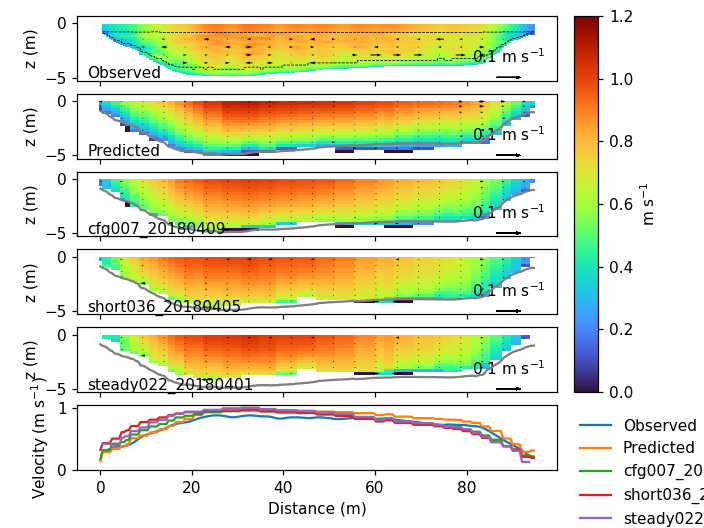

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T11:29:30.500000000
Bed offset is  -1.5969936473118278


<IPython.core.display.Javascript object>


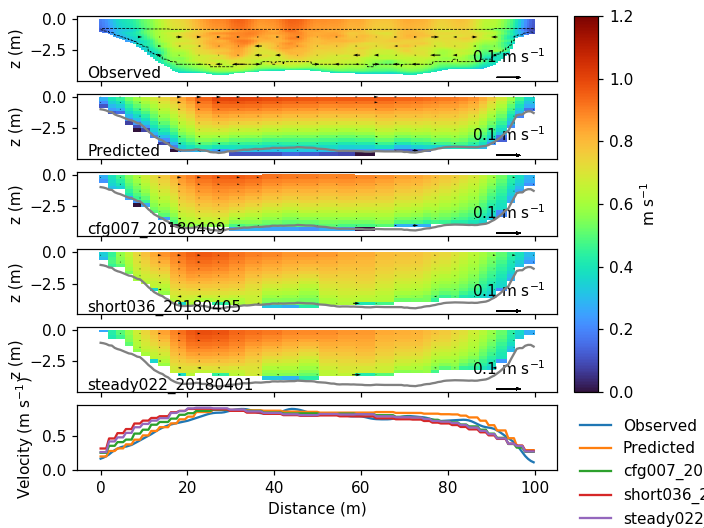

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T12:00:24.000000000
Bed offset is  -1.457235649122807


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T12:00:24.000000000
Bed offset is  -1.457235649122807
Extracting transect for time -1
Bed offset is  -1.3024484970760235
Extracting transect for time -1
Bed offset is  -1.3024484970760235


<IPython.core.display.Javascript object>


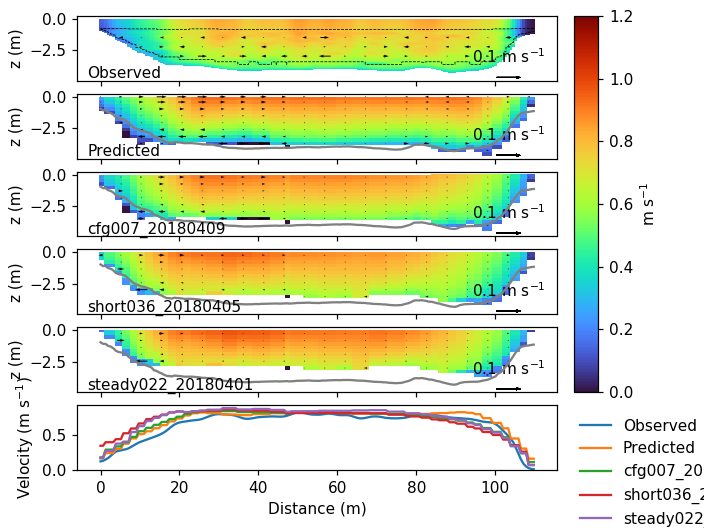

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T12:34:19.500000000
Bed offset is  -1.4096199277864991


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T12:34:19.500000000
Bed offset is  -1.4096199277864991
Extracting transect for time -1
Bed offset is  -1.2702476365777082
Extracting transect for time -1
Bed offset is  -1.2702476365777082


<IPython.core.display.Javascript object>


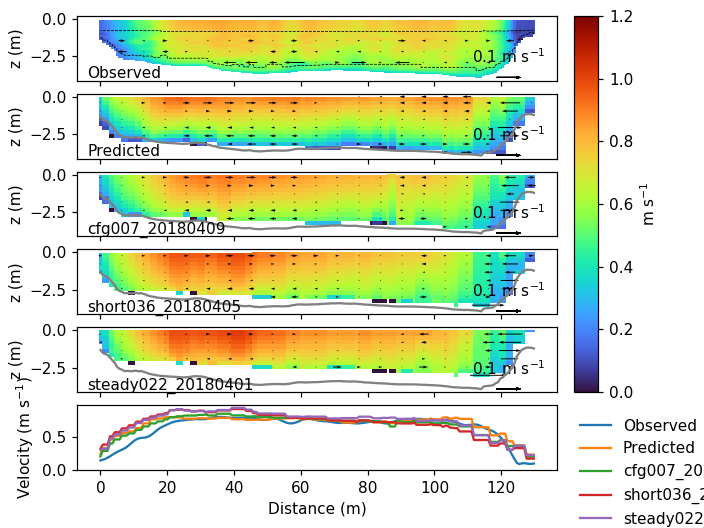

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T13:06:22.500000000
Bed offset is  -1.4086690841121494


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T13:06:22.500000000
Bed offset is  -1.4086690841121494
Extracting transect for time -1
Bed offset is  -1.2630814299065423
Extracting transect for time -1
Bed offset is  -1.2630814299065423


<IPython.core.display.Javascript object>


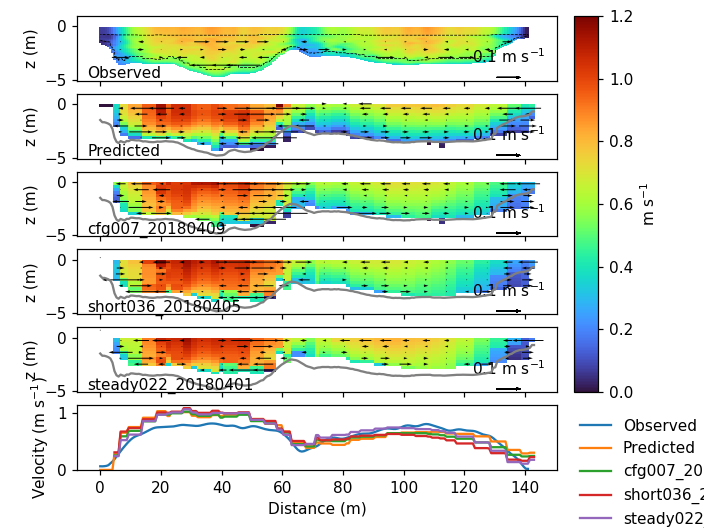

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T13:37:19.500000000


INFO:root:extract_transect: chain back


Bed offset is  -1.2249243979328164
Extracting transect for time 2018-04-05T13:37:19.500000000
Bed offset is  -1.2249243979328164
Extracting transect for time -1
Bed offset is  -1.0902730180878553
Extracting transect for time -1
Bed offset is  -1.0902730180878553


<IPython.core.display.Javascript object>


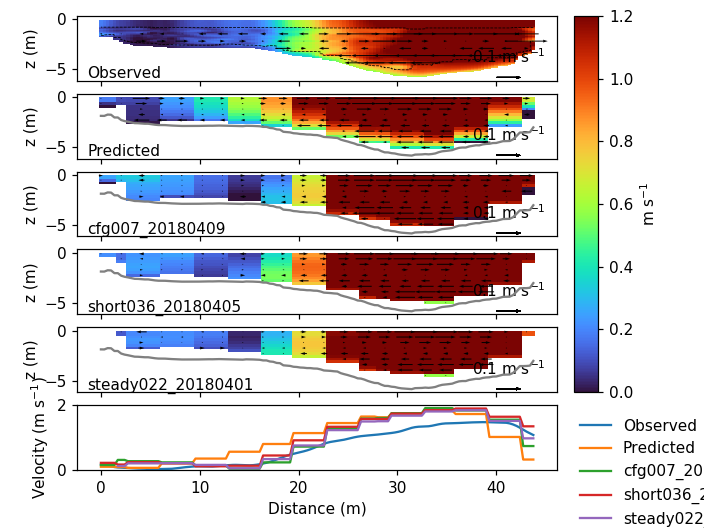

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T14:12:15.000000000
Bed offset is  -1.845859557581898
Extracting transect for time 2018-04-05T14:12:15.000000000


INFO:root:extract_transect: chain back


Bed offset is  -1.845859557581898
Extracting transect for time -1
Bed offset is  -1.748089415737926
Extracting transect for time -1
Bed offset is  -1.748089415737926


<IPython.core.display.Javascript object>


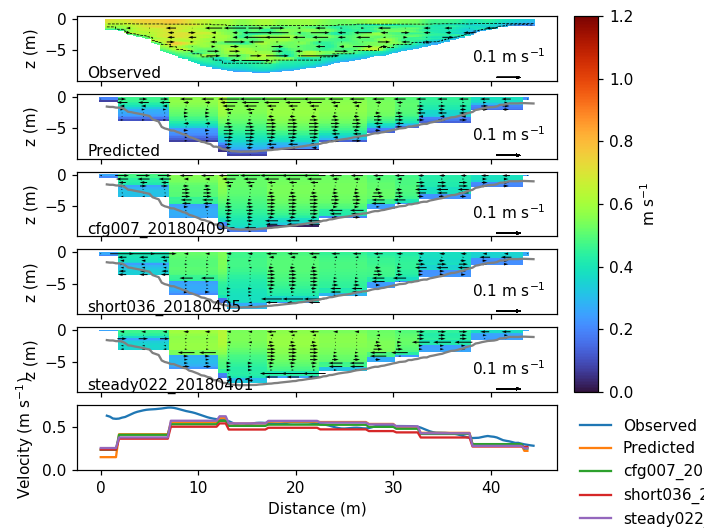

In [882]:
for t in obs_trans:
    F=FigU(t,labels=['Observed','Predicted'],z_slice=[-2,0],lateral_quiver=True)
    F.fig.savefig(os.path.join(fig_dir,'tran-%s-slice_with_top2m.png'%t.label),dpi=200)

In [883]:
z_slice=[-2.0,0]
#z_slice=None

recs=[]

for obs_tran in obs_trans:
    obs_tran=obs_tran.copy()
    smooth_adcp(obs_tran)
    mod_trans=[extract_to_match_obs(obs_tran,model)
               for model in models]
    trans=[obs_tran] + mod_trans

    # Resample each vertically to just the slice we care about
    if z_slice is not None:
        new_z=np.linspace(z_slice[0],z_slice[1],20)
        trans=[xr_transect.resample_z(tran,new_z,new_z_positive='up')
               for tran in trans]
    # Get on a common lateral coordinate:
    trans=xr_transect.resample_to_common(trans,resample_z=False,save_original=None)

    depth_averages=[ xr_transect.depth_avg(t,'U') for t in trans]

    obs_davg=depth_averages[0]
    mod_davgs=depth_averages[1:]
    row=dict(label=obs_tran.label)
    
    for model,mod_davg in zip(models,mod_davgs): 
        err=mod_davg-obs_davg
        err_mag=utils.mag(err.values)
        err_mean=np.nanmean(err.values,axis=0)

        row[model.label+'_mae']=np.nanmean(err_mag)
        #row[model.label+'_rmse']=np.sqrt(np.nanmean(err_mag**2))
        #row[model.label+"_bias_u"]=err_mean[0]
        row[model.label+'_bias_v']=err_mean[1]
        
    recs.append(row)
err_df=pd.DataFrame(recs)
err_df

INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-03T13:29:48.500000000
Bed offset is  -1.6180730979462874


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-03T13:29:48.500000000
Bed offset is  -1.6180730979462874
Extracting transect for time -1
Bed offset is  -1.4730292022116904
Extracting transect for time -1
Bed offset is  -1.4730292022116904


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-04T08:49:52.500000000
Bed offset is  -1.415501032720063


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-04T08:49:52.500000000
Bed offset is  -1.415501032720063
Extracting transect for time -1
Bed offset is  -1.2999786109323541
Extracting transect for time -1
Bed offset is  -1.2999786109323541


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T11:03:34.000000000
Bed offset is  -1.5486122612612612


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T11:03:34.000000000
Bed offset is  -1.5486122612612612
Extracting transect for time -1
Bed offset is  -1.3951065207207205
Extracting transect for time -1
Bed offset is  -1.3951065207207205


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T11:29:30.500000000
Bed offset is  -1.5969936473118278


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T11:29:30.500000000
Bed offset is  -1.5969936473118278
Extracting transect for time -1
Bed offset is  -1.4404592021505376
Extracting transect for time -1
Bed offset is  -1.4404592021505376


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T12:00:24.000000000
Bed offset is  -1.457235649122807


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T12:00:24.000000000
Bed offset is  -1.457235649122807
Extracting transect for time -1
Bed offset is  -1.3024484970760235
Extracting transect for time -1
Bed offset is  -1.3024484970760235


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T12:34:19.500000000
Bed offset is  -1.4096199277864991


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T12:34:19.500000000
Bed offset is  -1.4096199277864991
Extracting transect for time -1
Bed offset is  -1.2702476365777082
Extracting transect for time -1
Bed offset is  -1.2702476365777082


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T13:06:22.500000000
Bed offset is  -1.4086690841121494


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T13:06:22.500000000
Bed offset is  -1.4086690841121494
Extracting transect for time -1
Bed offset is  -1.2630814299065423
Extracting transect for time -1
Bed offset is  -1.2630814299065423


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T13:37:19.500000000


INFO:root:extract_transect: chain back


Bed offset is  -1.2249243979328164
Extracting transect for time 2018-04-05T13:37:19.500000000
Bed offset is  -1.2249243979328164
Extracting transect for time -1
Bed offset is  -1.0902730180878553
Extracting transect for time -1
Bed offset is  -1.0902730180878553


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T14:12:15.000000000
Bed offset is  -1.845859557581898


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T14:12:15.000000000
Bed offset is  -1.845859557581898
Extracting transect for time -1
Bed offset is  -1.748089415737926
Extracting transect for time -1
Bed offset is  -1.748089415737926


,label,cfg008_20180409_mae,cfg008_20180409_bias_v,cfg007_20180409_mae,cfg007_20180409_bias_v,short036_20180405_mae,short036_20180405_bias_v,steady022_20180401_mae,steady022_20180401_bias_v
0,040318_1_,0.074186,0.003437,0.052627,-0.024215,0.067447,0.024142,0.066469,0.012802
1,040518_2,0.084283,0.034920,0.041930,0.011059,0.071300,0.042451,0.069177,0.044921
2,040518_3_,0.077633,0.048434,0.068094,0.019772,0.095820,0.023357,0.094797,0.029565
3,040518_4,0.054196,0.024343,0.056276,0.010828,0.087622,0.011213,0.074979,0.018130
4,040518_5,0.061396,0.034408,0.069925,0.028190,0.101756,0.033298,0.097095,0.044831
5,040518_6,0.081789,0.021663,0.079055,0.016138,0.125540,0.016513,0.117870,0.041933
6,040518_7_,0.177601,0.021223,0.161130,0.021155,0.196643,0.004506,0.147602,0.045332
7,040518_8,0.384983,-0.187550,0.300208,-0.043676,0.292498,-0.066308,0.257159,-0.042716
8,040518_9,0.103196,0.004919,0.094886,-0.013758,0.119273,-0.040992,0.103740,-0.030663


In [ ]:
for tran in all_trans:
    if tran.z_ctr.attrs.get('positive','up')=='down':
        assert tran.z_ctr.mean()>0
        assert np.nanmean(np.diff(tran.z_ctr)) > 0
    else:
        assert tran.z_ctr.mean()<0
        assert np.nanmean(np.diff(tran.z_ctr))<0
    

In [574]:
from stompy.io.local import cdec
cache_dir='cache'
# Get stage from OR
stage_or=cdec.cdec_dataset(station="OH1",
                           start_date=np.datetime64("2018-03-30"),
                           end_date=np.datetime64("2018-04-15"),
                           sensor=1,
                           cache_dir=cache_dir)

INFO:cdec:Cached   2018-03-01 00:00:00 -- 2018-04-01 00:00:00
INFO:cdec:Cached   2018-04-01 00:00:00 -- 2018-05-01 00:00:00


In [871]:
# Closer look at vertical profiles:
vert_models=[
    models[0],
    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/cfg007_20180330"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady011_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady010_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady009_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady008_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady007_20180401"),
    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady007_20180401-rerun"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady005_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady012_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady013_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady014_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady015_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady016_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady017_20180401"),    
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady018_20180401"),    
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady019_20180401"),
    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady022_20180401"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady034_20180401"),
    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady035_20180401"),
    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short036_20180405"),
    
]

for m in vert_models:
    try:
        m.label
    except AttributeError:
        m.label=os.path.basename(m.run_dir)

In [872]:
obs_tran=obs_trans[3].copy()
smooth_adcp(obs_tran,wx=15,wz=0)

mod_trans=[extract_to_match_obs(obs_tran,model)
           for model in vert_models]

Extracting transect for time 2018-04-05T11:29:30.500000000
Bed offset is  -1.5969936473118278
Extracting transect for time -1
Bed offset is  -1.5969936473118278
Extracting transect for time -1
Bed offset is  -1.4404592021505376
Extracting transect for time -1
Bed offset is  -1.4404592021505376
Extracting transect for time -1
Bed offset is  -1.4404592021505376


In [873]:
tidx=utils.nearest(stage_or.time, obs_tran.time)
stage_or_now=0.3048*stage_or.sensor0001.values[tidx]
print("HOR stage at time of transect is",stage_or_now)

HOR stage at time of transect is 2.1915120000000003


<IPython.core.display.Javascript object>


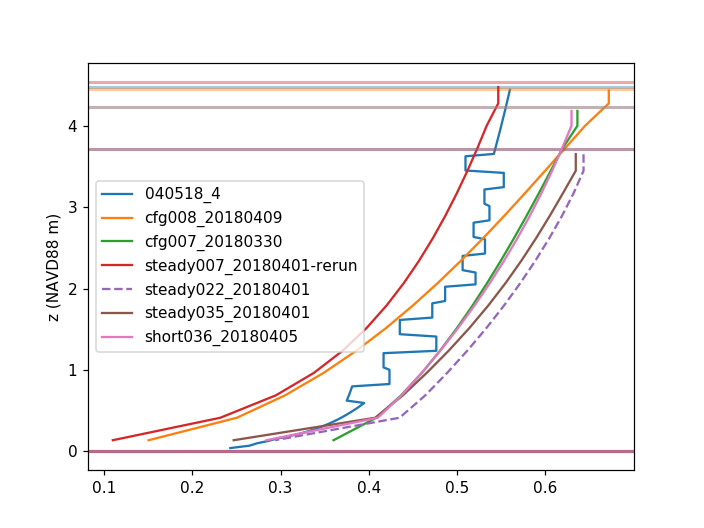

Local z_shift=4.4538  Transect z_shift=1.3362643243148244
Local z_shift=4.2268  Transect z_shift=1.5632249180812319
Local z_shift=4.5377  Transect z_shift=1.2523560675028182
Local z_shift=3.7133  Transect z_shift=2.076734088101458
Local z_shift=3.7179  Transect z_shift=2.072127750957966
Local z_shift=4.2248  Transect z_shift=1.5652234771892874


In [875]:
samp=obs_tran.dims['sample']//2
samp=40

plt.figure()
for t in [obs_tran]+mod_trans:
    wc=t.isel(sample=samp)
    #if 'U_nofill' in wc:
    #    U=wc.U_nofill
    #    plt.plot( U.isel(xy=1), xr_transect.pos_up(wc,'z_ctr'), label=t.label)
    U=wc.U
      
    # Show all plots with bed at 0.
    # data above is referenced to freesurface
    z_shift=-float(xr_transect.pos_up(wc,'depth_m')) 
    if 'z_shift' in t.attrs:
        print(f"Local z_shift={z_shift:.4f}  Transect z_shift={t.attrs['z_shift']}")
    
    l=plt.plot( U.isel(xy=1), z_shift + xr_transect.pos_up(wc,'z_ctr'), label=t.label)
    if 'steady022' in t.label:
        l[0].set_linestyle('--')

    plt.axhline( z_shift-wc.depth_m,color=l[0].get_color(),lw=2,alpha=0.4)
    plt.axhline( z_shift,color=l[0].get_color(),lw=2,alpha=0.4)
    
plt.ylabel('z (NAVD88 m)')
plt.legend()

In [815]:
#model=vert_models[-1]
model0=sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady022_20180401")
model=sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/steady034_20180401")

models=[model0,model]

In [816]:
maps=[xr.open_dataset(model.map_outputs()[0]) for model in models]

In [817]:
gs=[unstructured_grid.UnstructuredGrid.read_ugrid(map_ds)
    for map_ds in maps]

<IPython.core.display.Javascript object>


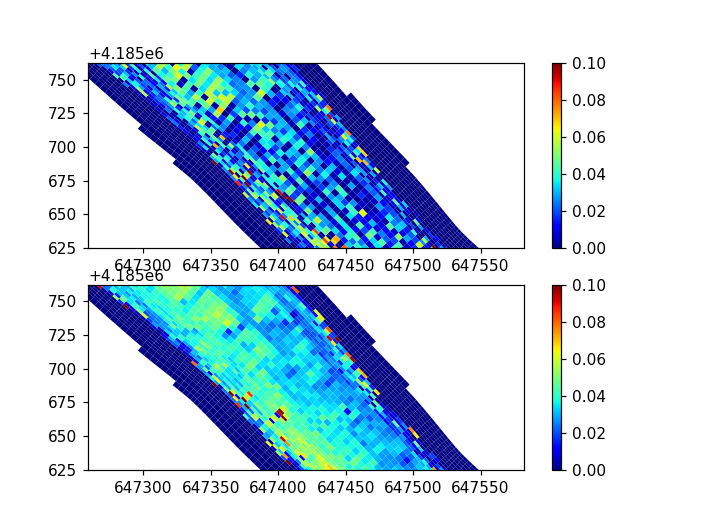

k=8  z_r[k]=2.34358175  c=1434 eta[c]=-2.071173110506296
k=8  z_r[k]=2.34358175  c=1434 eta[c]=-2.0661663492270725


In [820]:
zoom=np.array([647347.00, 647494.48, 4185625., 4185762.])
k=8

fig,axs=plt.subplots(len(maps),1)

for map_ds,ax,g in zip(maps,axs,gs):
    c=g.select_cells_nearest( [zoom[:2].mean(), zoom[2:].mean()])
    z=map_ds.z_r.isel(Nk=k).values
    eta=map_ds.eta.isel(time=-1,Nc=c).values
    print(f"k={k}  z_r[k]={z}  c={c} eta[c]={eta}")

    if 1: # turb_q
        ccoll=g.plot_cells(values=map_ds.turb_q.isel(Nk=k,time=-1),cmap='jet',
                           ax=ax)
        ccoll.set_clim([0,0.1])
    if 0: # turb_time scale = q^2/eps = l/q = 1/omega
        tau=map_ds.turb_l.isel(Nk=k,time=-1) / map_ds.turb_q.isel(Nk=k,time=-1)
        ccoll=g.plot_cells(values=tau,cmap='jet',
                           ax=ax)
        ccoll.set_clim([0,10])
        
    plt.colorbar(ccoll,ax=ax)
    ax.axis('equal')
    ax.axis(zoom)


<IPython.core.display.Javascript object>


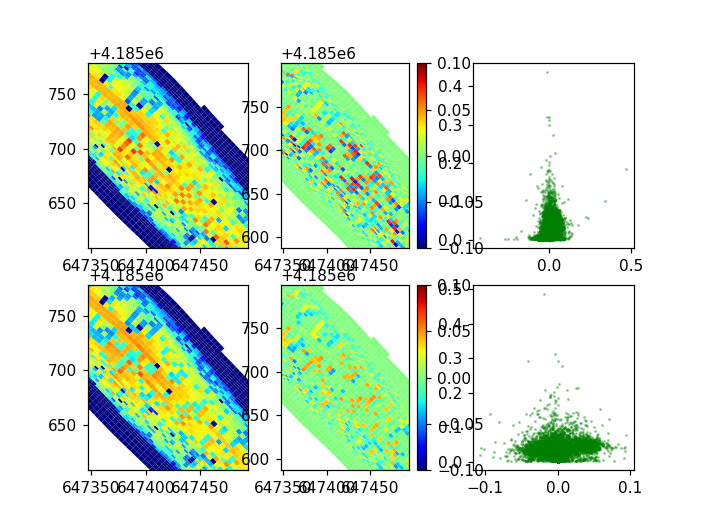

In [821]:
zoom=np.array([647347.00, 647494.48, 4185625., 4185762.])

fig,axs=plt.subplots(len(maps),3)

for map_ds,ax,axs,axt,g in zip(maps,axs[:,0],axs[:,1],axs[:,2],gs):
    ds=map_ds.rename_vars({'Nk':"Nkc"}).isel(time=-1)
    umag=np.sqrt(ds.uc**2 + ds.vc**2)
    umag_bed=umag.isel( Nk=ds.Nkc-1 )
    ccoll=g.plot_cells(values=umag_bed,cmap='jet',
                           ax=ax)
    ccoll.set_clim([0,1.0])
    
    w_bed=ds.w.isel( Nkw=ds.Nkc-1 )
    ccoll=g.plot_cells(values=w_bed,cmap='jet',
                       ax=axs)
    ccoll.set_clim([-0.1,0.1])
    
    plt.colorbar(ccoll,ax=axs)
    ax.axis('equal')
    ax.axis(zoom)
    axs.axis('equal')
    axs.axis(zoom)

    axt.plot(w_bed,ds.turb_q.isel(Nk=k),'g.',ms=2,alpha=0.3)

In [785]:
ds

<xarray.Dataset>
Dimensions:        (Nc: 12720, Ne: 25740, Nk: 50, Nkw: 51, Np: 13021, Two: 2, numsides: 4)
Coordinates:
    xv             (Nc) float64 6.471e+05 6.475e+05 ... 6.472e+05 6.472e+05
    yv             (Nc) float64 4.186e+06 4.186e+06 ... 4.186e+06 4.186e+06
    xe             (Ne) float64 ...
    ye             (Ne) float64 ...
    z_r            (Nk) float64 ...
    z_w            (Nkw) float64 ...
    Nkc            (Nc) int32 24 1 9 16 8 16 16 10 16 13 ... 1 1 1 1 1 1 1 1 1 1
    time           datetime64[ns] 2018-04-01T04:00:00
Dimensions without coordinates: Nc, Ne, Nk, Nkw, Np, Two, numsides
Data variables:
    suntans_mesh   int32 ...
    cells          (Nc, numsides) int32 9755 4431 9646 7641 ... 6932 13020 13019
    nfaces         (Nc) int32 ...
    face           (Nc, numsides) int32 ...
    edges          (Ne, Two) int32 4431 9646 9646 7641 ... 8001 13020 13020 9354
    neigh          (Nc, numsides) int32 ...
    grad           (Ne, Two) int32 ...
    xp      

In [884]:
# What is different between cfg007, the leading contender, and
# short036, which should be good but isn't that great.
models=[sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/cfg007_20180409"),
    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short036_20180405"),
       ]


In [885]:
models[0].grid

<IPython.core.display.Javascript object>


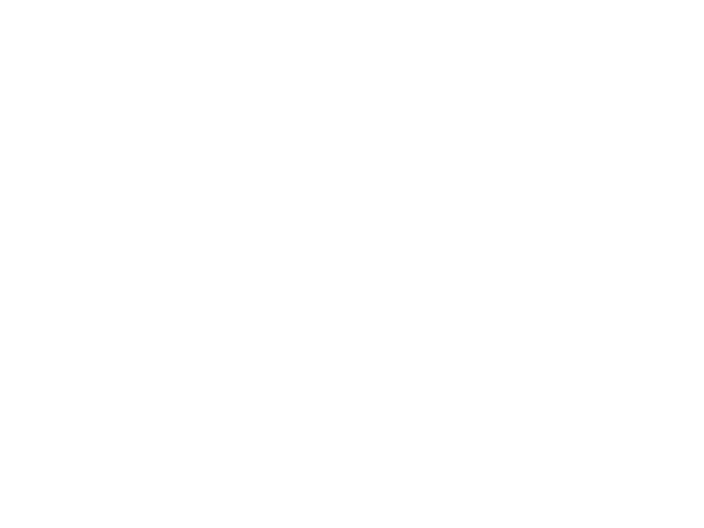

(646786.6675765, 648104.0773735, 4185415.4918699996, 4186223.74393)

In [886]:
# Grid geometry:
fig,axs=plt.subplots(1,2,sharex=True,sharey=True)
plt.setp(axs, adjustable='datalim')

for model,ax in zip(models,axs):
    model.grid.plot_edges(ax=ax,lw=0.4,color='k')

axs[0].axis('equal')